# Impoart

In [1]:
import import_ipynb
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

import bbox_visualizer as bbv

from MaskRCNN_VOC import *


import mh_utils as MH
from MaskRCNN_VOC import VOC2012_MaskRCNN_InstanceSegmentation as Task
from MaskRCNN_VOC import VOC2012_MaskRCNN_InstanceSegmentation_Dataset as TaskDataset
from MaskRCNN_VOC import VOC2012_MaskRCNN_InstanceSegmentation_DataLoader as TaskDataloader


importing Jupyter notebook from MaskRCNN_VOC.ipynb
importing Jupyter notebook from mh_utils.ipynb
-3
-2


/opt/conda/lib/python3.8/site-packages/nbformat/__init__.py:93: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


# Device

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset (Pascal VOC 2012)

In [3]:
dataset = TaskDataset(root = "/home/VOCdevkit/VOC2012", image_set = "val", cropping = False)
data_loader = TaskDataloader(dataset, batch_size = 1)

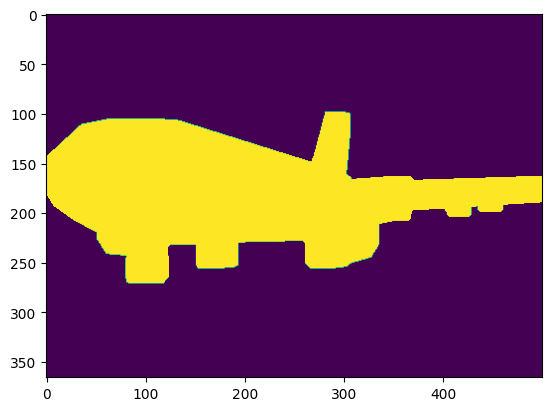

In [5]:


mask = Converter.tensor_to_numpy(dataset[0][1]["masks"][0])
mask = MH.expend_mask(mask, 10)

plt.imshow(mask)

# Model

In [ ]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(pretrained=True)
model.roi_heads.box_predictor.cls_score = torch.nn.Linear(in_features=1024, out_features=21, bias=True)
model.roi_heads.box_predictor.bbox_pred = torch.nn.Linear(in_features=1024, out_features=84, bias=True)
model.roi_heads.mask_predictor.mask_fcn_logits = torch.nn.Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
model.to(device)
# model.load_state_dict(torch.load("models/trained_model_with_expending_v1(500-epoch)"))
model.load_state_dict(torch.load("models/trained_model(500-epoch)"))

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

# Eval

In [7]:
CLASS_NUM = Task.CLASS_NUM
MASK_THRESHOLD = 0.4
SCORE_THRESHOLDS = Task.SCORE_THRESHOLDS

Task.map_eval(model, device, data_loader, 
    class_num = CLASS_NUM, 
    mask_threshold = MASK_THRESHOLD,
    score_threshold = SCORE_THRESHOLDS)

100%|██████████| 1444/1444 [02:22<00:00, 10.10it/s]


0.1370104845032858

In [ ]:
def eval_sample(model, sample, device = "cpu"):
    model.eval()
    model.to(device)
    image, target = Task.sample_to(sample, device)
    return model(image, target)

sample_result = eval_sample(model, dataset[0], device)
Task.show_sample_result(sample_result)


AttributeError: type object 'VOC2012_MaskRCNN_InstanceSegmentation' has no attribute 'sample_to'

hello1
hello2
hello3
hello4
hello5


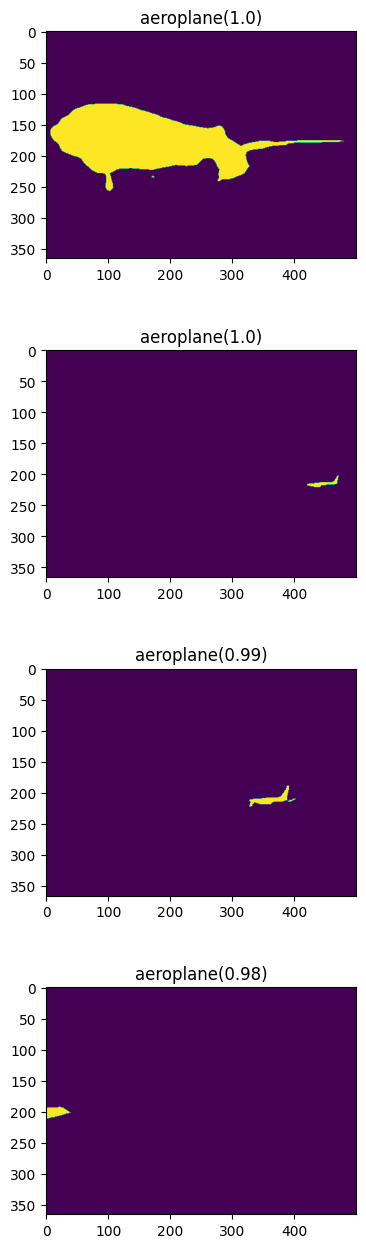

# Result

In [15]:
def to_numpy(x):
    return np.array(x.to("cpu").detach())

def binary_masks_to_label_mask(masks, labels):
    """
        masks: N개의 binary mask [Numpy (N x W x H)]
    """
    
    return (masks * labels[:, None, None]).max(0)



tensor([[25166, 25166, 25166],
        [  233,   233,   233],
        [  616,   616,   616],
        [    0,     0,     0],
        [    0,     0,     0],
        [    0,     0,     0]], dtype=torch.int32)


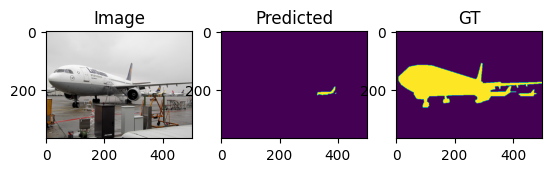

In [34]:
def show(image, sp_label_mask, gt_label_mask):
    fig = plt.figure()

    titles = ["Image","Predicted", "GT"]
    images = [image, sp_label_mask[:, :, None], gt_label_mask[:, :, None]]

    for i in range(3):
        sub = fig.add_subplot(1, 3, i+1)
        sub.set_title(titles[i])
        sub.imshow(images[i])
def analyze(image, target, result):
    image = to_numpy(image).transpose((1, 2, 0))
    # Sample GT
    gt_boxes  = to_numpy(target["boxes"])      # Numpy (N x 4)
    gt_labels = to_numpy(target["labels"])     # Numpy (N x 1)
    gt_masks  = to_numpy(target["masks"])      # Numpy (N x W x H)

    gt_label_mask = binary_masks_to_label_mask(gt_masks, gt_labels)

    # Sample Result (predicted)
    p_scores = to_numpy(result["scores"])           # Numpy (N' x 1)
    p_labels = to_numpy(result["labels"])           # Numpy (N' x 1)
    p_boxes = to_numpy(result["boxes"])             # Numpy (N' x 4)
    p_masks = to_numpy(result["masks"]).squeeze(1)>0.5  # Numpy (N' x W x H)

    p_label_mask = binary_masks_to_label_mask(p_masks, p_labels)

    selected_idxes = torchvision.ops.nms(torch.tensor(p_boxes, dtype = torch.float), torch.tensor(p_scores, dtype = torch.float), 0.3)
#     selected_idxes = selected_idxes[2:3]
    sp_scores = np.array([p_scores[i] for i in selected_idxes])
    sp_labels = np.array([p_labels[i] for i in selected_idxes])
    sp_boxes = np.array([p_boxes[i] for i in selected_idxes])
    sp_masks = np.array([p_masks[i] for i in selected_idxes])

    sp_label_mask = binary_masks_to_label_mask(sp_masks, sp_labels)
    
    iou_matrix = mask_iou(torch.tensor(p_masks, dtype = torch.int32), torch.tensor(gt_masks, dtype = torch.int32))
    show(image, sp_label_mask, gt_label_mask)
#     is_true(p_masks, p_labels, p_scores, gt_masks, gt_labels, class_num = 21)
    
analyze(images[0], targets[0], results[0])

In [44]:

    


def show_mask_result(pre, gt):
    fig = plt.figure()
    sub1 = fig.add_subplot(1, 2, 1)
    sub1.imshow(pre)
    sub1.set_title("Predicted Mask")
    
    sub2 = fig.add_subplot(1, 2, 2)
    sub2.imshow(gt)
    sub2.set_title("GT Mask")
    
def extract_mask_with_threshold(mask, threshold):
    return (mask>threshold).astype(np.uint8)

# def extract_mask_with_threshold(mask, threshold_list):
#     """
#         mask를 각각의 threshold에 맞게 추출
#     """
#     return 
#     return [(mask>threshold) for threshold in threshold_list]


# instance_idx = 0 # instance index in a result
# gt_box, gt_label, gt_mask = gt_boxes[instance_idx], gt_labels[instance_idx], gt_masks[instance_idx]
# p_box, p_label, p_mask = sp_boxes[instance_idx], sp_labels[instance_idx], sp_masks[instance_idx]


threshold_list = [0.1 * x for x in range(1, 11)]
binary_masks = extract_mask_with_threshold(p_masks, 0.5)

iou = IoU(p_mask, gt_mask)

# show_mask_result(p_masks[1], gt_mask)

print(labels)
label_mask = binary_masks_to_label_mask(binary_masks, labels)

np.unique(binary_masks.shape)

NameError: name 'p_mask' is not defined

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataset = VOC2012_MaskRCNN_InstanceSegmentation_Dataset(root = "/home/VOCdevkit/VOC2012", image_set = "val")
data_loader = VOC2012_MaskRCNN_InstanceSegmentation_DataLoader(dataset, batch_size = 10)

model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(pretrained=True)
model.roi_heads.box_predictor.cls_score = torch.nn.Linear(in_features=1024, out_features=21, bias=True)
model.roi_heads.box_predictor.bbox_pred = torch.nn.Linear(in_features=1024, out_features=84, bias=True)
model.roi_heads.mask_predictor.mask_fcn_logits = torch.nn.Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
model.to(device)
model.load_state_dict(torch.load("models/trained_model_v2(500-epoch)"))


sample = dataset[0]
Task.show_comparison_for_one_sample(model, sample, device, iou_threshold=0.3, mask_binary_threshold=0.3)

NameError: name 'VOC2012_MaskRCNN_InstanceSegmentation_Dataset' is not defined